In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gluonts
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset, StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week
from PythonFiles.Configuration import Configuration
config = Configuration()
df = pd.read_csv("Influenza.csv", sep=',')

In [2]:
# Because of simplicity, only consider the first 10 locations
locations = list(df.location.unique())

# Process the df into a uniformly spaced df
one_ts_df = df.loc[df.location.isin(locations), ["value", 'location', 'date']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")

# seperate the intervals for training and testing
train_set_df = one_ts_df.loc[(one_ts_df.index <= config.train_end_time) &
                          (one_ts_df.index >= config.train_start_time),:]

test_set_df = one_ts_df.loc[(one_ts_df.index >= config.train_start_time) &
                         (one_ts_df.index <= config.test_end_time),:]

# Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set_df,
                                              item_id='location',
                                              target="value",
                                              freq=config.freq)

test_set = PandasDataset.from_long_dataframe(dataframe=test_set_df,
                                             item_id='location',
                                             target="value",
                                             freq=config.freq)

# Determine the Starting and ending time of the test_set_df
start_time = min(test_set_df.index.difference(train_set_df.index))
end_time = max(test_set_df.index.difference(train_set_df.index))
test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy = StepStrategy(prediction_length=4, step_size=1),
                                    start_time = pd.Period(start_time, config.freq),
                                    end_time = pd.Period(end_time, config.freq)
                                   )

In [3]:
forecasts, tss = model(config, train_set, test_set)

100%|██████████| 50/50 [00:05<00:00,  9.22it/s, epoch=4/4, avg_epoch_loss=0.824]


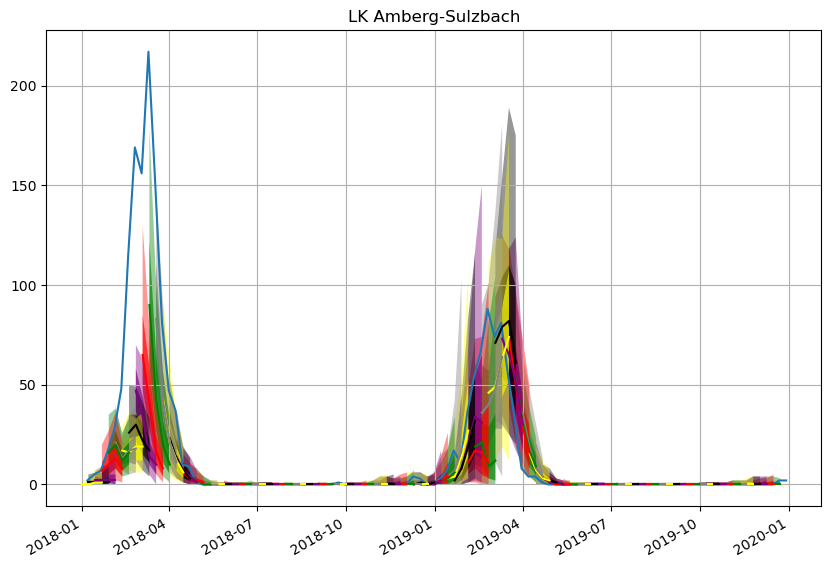

In [4]:
windows_per_location = int(len(test_set) / len(locations))
for location in locations[3:4]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((one_ts_df.loc[(one_ts_df['location'] == location) &
                            (one_ts_df.index <= config.test_end_time) &
                            (one_ts_df.index >= config.train_end_time)].index),
             one_ts_df.loc[(one_ts_df['location'] == location) &
                           (one_ts_df.index <= config.test_end_time) &
                           (one_ts_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #define the colors to use for each different window
    color = ["g", "r", "purple", "black", "yellow", "grey"] * windows_per_location
    # Iterate through the correct index by changing the range with [windows_per_location]
    for k in range(0 + windows_per_location*locations.index(location),
                   windows_per_location + windows_per_location*locations.index(location)):
        forecast_entry = forecasts[k]
        prediction_intervals = (50.0, 90.0)
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()

## Splitting the Forecasts into their week ahead composition

In [7]:
one_week_ahead_forecasts=[]
for location in locations:
    start_date_list = []
    # define the index of the time wise first forecast point
    first_time_point_of_location = windows_per_location + windows_per_location*locations.index(location)-1
    # save the array corresponding to the first week 
    weekly_samples_array = forecasts[first_time_point_of_location].samples[:,:1]
    # also append the time wise first [start_date] to [start_date_list]
    start_date_list.append(forecasts[first_time_point_of_location].start_date)
    for k in range(first_time_point_of_location - 1,
                   first_time_point_of_location - windows_per_location, -1):
        
        weekly_samples_array = np.concatenate((weekly_samples_array, forecasts[k].samples[:, :1]), axis=1)
        start_date_list.append(forecasts[k].start_date)
    
    one_week_ahead_forecasts.append(gluonts.model.forecast.SampleForecast(
        info=forecasts[first_time_point_of_location].info,
        item_id=forecasts[first_time_point_of_location].item_id,
        samples=weekly_samples_array,
        start_date=min(start_date_list)))

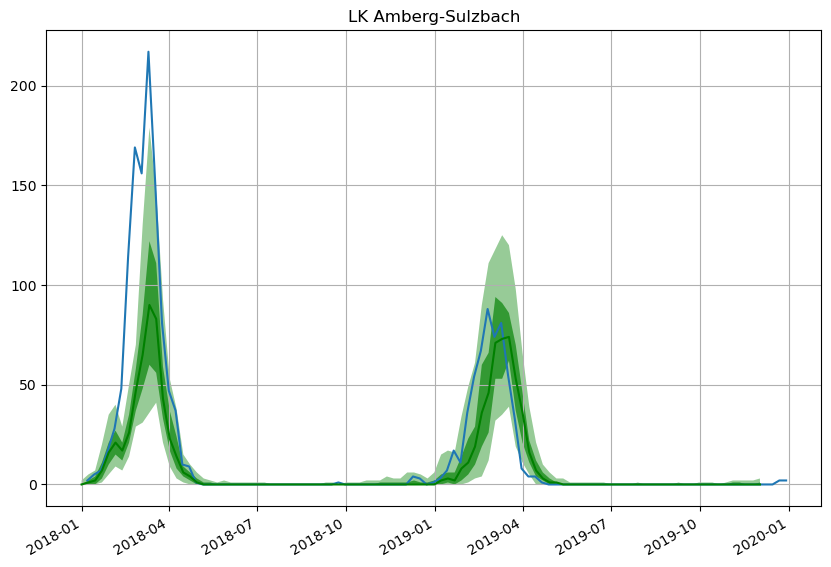

In [8]:
# PLot the Splitted Forecasts for each location
for location in locations[3:4]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((one_ts_df.loc[(one_ts_df['location'] == location) &
                            (one_ts_df.index <= config.test_end_time) &
                            (one_ts_df.index >= config.train_end_time)].index),
             one_ts_df.loc[(one_ts_df['location'] == location) &
                           (one_ts_df.index <= config.test_end_time) &
                           (one_ts_df.index >= config.train_end_time), 'value'])
    #define the colors to use for each different window
    color = ["g", "r", "purple", "black", "yellow", "grey"]
    forecast_entry = one_week_ahead_forecasts[locations.index(location)]
    prediction_intervals = (50.0, 90.0)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()

### Use the Implementation within model.py

In [9]:
two_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)
one_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)
three_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)
four_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)

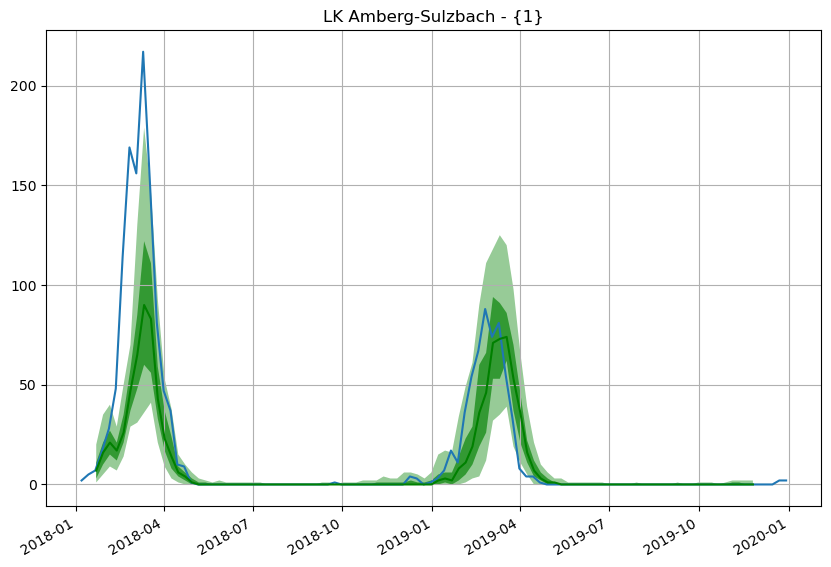

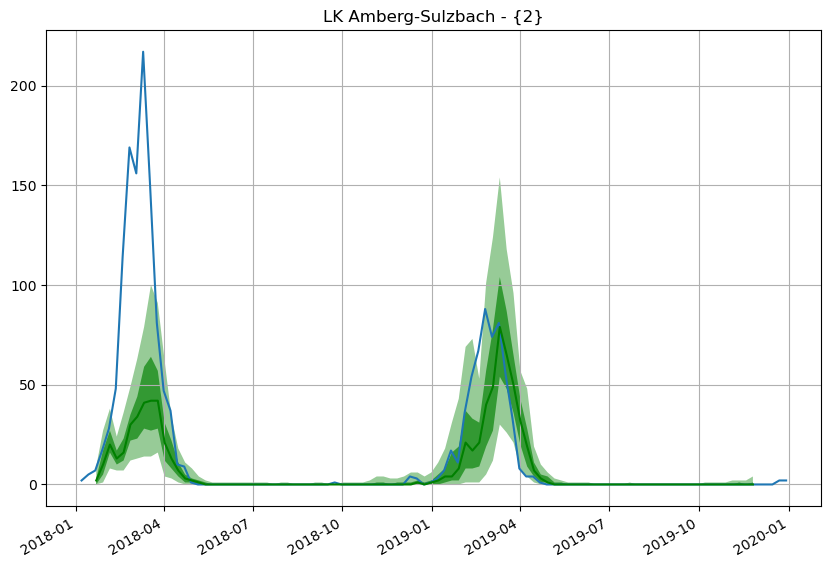

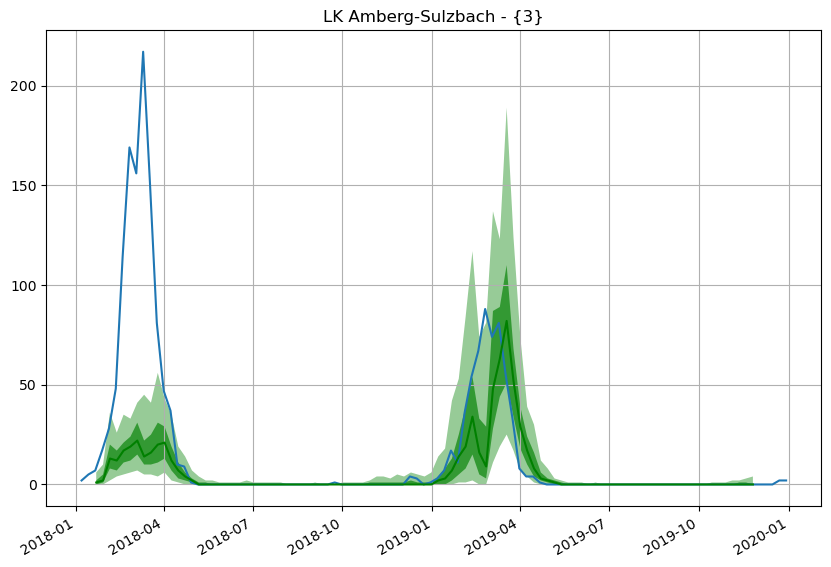

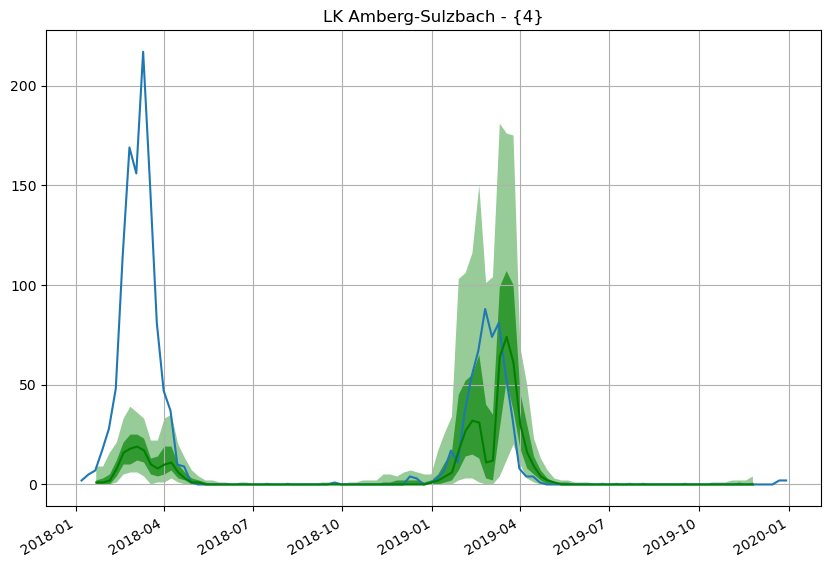

In [10]:
forecast_dict ={1 : one_week_ahead_forecasts,
                2 : two_week_ahead_forecasts,
                3 : three_week_ahead_forecasts,
                4 : four_week_ahead_forecasts}
for forecast in forecast_dict.values():
    # PLot the Splitted Forecasts for each location
    for location in locations[3:4]:
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        plt.title(f'{location} - {d}')
        # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
        plt.plot((one_ts_df.loc[(one_ts_df['location'] == location) &
                                (one_ts_df.index <= config.test_end_time) &
                                (one_ts_df.index >= config.train_end_time)].index),
                 one_ts_df.loc[(one_ts_df['location'] == location) &
                               (one_ts_df.index <= config.test_end_time) &
                               (one_ts_df.index >= config.train_end_time), 'value'])
        #define the colors to use for each different window
        color = ["g", "r", "purple", "black", "yellow", "grey"]
        forecast_entry = forecast[locations.index(location)]
        prediction_intervals = (50.0, 90.0)
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
        plt.grid(which="both")
        plt.show()

In [12]:
evaluator=Evaluator(quantiles=[0.1, 0.2, 0.5, 0.8, 0.9])
evaluator_df = pd.DataFrame()
for location in locations[3:4]:
    for forecast in forecast_dict.values():
        agg_metrics, item_metrics = evaluator(split_tss, forecast)
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
        evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
print(evaluator_df)

Running evaluation: 411it [00:01, 400.36it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:00, 449.23it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:00, 465.42it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 408.53it/s]


                  item_id         forecast_start          MSE  abs_error  \
8  LK Amberg-Sulzbach {1}  2018-01-22/2018-01-28   392.206266      614.0   
8  LK Amberg-Sulzbach {2}  2018-01-22/2018-01-28   688.372342      855.0   
8  LK Amberg-Sulzbach {3}  2018-01-22/2018-01-28   948.583360     1025.0   
8  LK Amberg-Sulzbach {4}  2018-01-22/2018-01-28  1056.672600     1115.0   

   abs_target_sum  abs_target_mean  seasonal_error      MASE      MAPE  \
8          1637.0        16.876289        1.834975  3.449581  0.521226   
8          1637.0        16.876289        1.834975  4.803570  0.634190   
8          1637.0        16.876289        1.834975  5.758666  0.826146   
8          1637.0        16.876289        1.834975  6.264305  0.949739   

      sMAPE  ...  QuantileLoss[0.1]  Coverage[0.1]  QuantileLoss[0.2]  \
8  0.687991  ...              215.0       0.000000              370.0   
8  0.715848  ...              239.4       0.000000              430.8   
8  0.851549  ...             

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
